In [1]:
# Import general python packages used by scientists
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gc

# Import packages  Image Access
import lsst.daf.butler as dafButler
import lsst.geom as geom
import lsst.afw.display as afwDisplay
import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
from lsst.geom import Point2D
from lsst.afw import cameraGeom

# Import packages for  Catalog Access
import pandas
pandas.set_option('display.max_rows', 1000)
from lsst.rsp import get_tap_service, retrieve_query

#Import custom packages
from ellipticity_mapping import calculate_ellipticity_on_xy
from collection_dictionary import collection_dictionary

from datetime import datetime, timedelta
from astroplan import Observer
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from pytz import all_timezones #To visualize all the possible timezones
from pytz import timezone

In [2]:
from astroplan import Observer
from astropy.time import Time, TimezoneInfo
import astropy.units as u
import pytz

day = "2023-03-10"  # local day at time of sunset
noon_cerro_pachon = Time(day)+15*u.h
print(Time(day))

2023-03-10 00:00:00.000


In [3]:
LSST_observer = Observer.at_site("LSST", timezone='America/Santiago')
# DateTime("2023-07-18T10:07:03.614199910", TAI = UTC + 37 sec
parangle_from_astroplan = LSST_observer.parallactic_angle(Time("2023-07-18T10:06:46.614199910")-timedelta(seconds=37), 
                                SkyCoord(60.4904550264, -38.1643749590, unit="deg", frame='icrs'))
print(parangle_from_astroplan)

-1.58808 rad


In [4]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [5]:
def pixel_to_focal(x, y, det):
    """
    Parameters
    ----------
    x, y : array
        Pixel coordinates.
    det : lsst.afw.cameraGeom.Detector
        Detector of interest.
    Returns
    -------
    fpx, fpy : array
        Focal plane position in millimeters in DVCS
        See https://lse-349.lsst.io/
    """
    tx = det.getTransform(cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
    fpx, fpy = tx.getMapping().applyForward(np.vstack((x, y)))
    return fpx.ravel(), fpy.ravel()

In [6]:
seqnum = 50
collection_dict = collection_dictionary()
visit_seqnum = 5023071800000 + seqnum

In [7]:
#OPZIONE MOLTO LENTA MA PIU' GENERICA, ora Skippa alla cella successiva
#se invece la lista dei CCD c'e l'hai gia
#scegli una visita (questa sappiamo avere molti CCD cosa che si puo' verificare )

#Define the butler data configuration and collection (una tantum ) 
config = '/home/v/vittorio/rubin-user/projects/imsim/imSim/repo'
collection = collection_dict[seqnum]

detectors = np.arange(189)

datasetType='calexp'
butler = dafButler.Butler(config,collections=collection)
point = geom.Point2D(2036, 2000)

# # Create the butler
# registry = butler.registry

# dataId = {'visit': visit_seqnum, 'detector': 94, 'band':'r'}
# # dataId = {'visit': N_visits}
# calexp = butler.get(datasetType, **dataId)
# sources = butler.get('src', dataId)

# datasetRefs = set(registry.queryDatasets(datasetType, dataId=dataId))
# rot = (calexp.info.getVisitInfo().getBoresightRotAngle()).asDegrees()

e_all = []
ex_all = []
ey_all = []
ex_all_rot = []
ey_all_rot = []
Nccd = []
xx = []
yy = []
xx_mm = []
yy_mm = []

for i, ref in enumerate(detectors):

    dataId = {'visit': visit_seqnum, 'detector': i, 'band':'r'}
    calexp = butler.get(datasetType, **dataId)
    rot = (calexp.info.getVisitInfo().getBoresightRotAngle()).asDegrees()
    
    ccd = calexp.detector.getId()
    det = calexp.getDetector()
    psf = calexp.getPsf()
    wcs = calexp.getWcs()
    calexp_info = calexp.getInfo()
    coo = wcs.pixelToSky(2036.0, 2000.0)
    fpx, fpy = pixel_to_focal(point[0], point[1], det)
    Ixx=psf.computeShape(point).getIxx()
    Iyy=psf.computeShape(point).getIyy()
    Ixy=psf.computeShape(point).getIxy()
    theta = np.arctan2(2. * Ixy, Ixx - Iyy) / 2.
    #theta.append(np.arctan2(2. * Ixy, Ixx - Iyy) / 2.)
    e1 = (Ixx - Iyy) / (Ixx + Iyy)
    e2 = (2. * Ixy) / (Ixx + Iyy)
    e = np.sqrt(e1**2 + e2**2)
    ex = e * np.cos(theta)
    ey = e * np.sin(theta)
    ex_rot = ex*np.cos(np.radians(rot)) - ey*np.sin(np.radians(rot))
    ey_rot = ex*np.sin(np.radians(rot)) + ey*np.cos(np.radians(rot))
    e_all.append(e)
    ex_all.append(ex)
    ey_all.append(ey)
    ex_all_rot.append(ex_rot)
    ey_all_rot.append(ey_rot)
    Nccd.append(ccd)
    xx.append(coo[0].asDegrees())
    yy.append(coo[1].asDegrees())
    xx_mm.append(fpx)
    yy_mm.append(fpy)
   
#print(e_all,Nccd)

#QUESTA VISUALIZZAZIONE NON È CORRETTA: BISOGNA FARE UNA DOPPIA ROTAZIONE

# plt.quiver(xx, yy, ex_all, ey_all, e_all,  scale=0.4,headlength=0., headwidth=1., pivot='mid', width=0.005)

# plt.text(xx, yy, [str(d) for d in list(detectors)])
# #plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
# #colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
# colorbar = plt.colorbar(label='ellipticity')
# plt.clim(0., 0.04)
# plt.xlabel('x [RA]')
# plt.ylabel('y [Dec]')
# plt.title('Ellipticity Sticks')
# plt.savefig("Ellipticity Sticks radec.jpg")

LookupError: Dataset calexp with data ID {instrument: 'LSSTCam', detector: 0, visit: 5023071800050} could not be found in collections ('pipetask_output/20231204T151417Z',).

In [ ]:
plt.quiver(xx_mm, yy_mm, ex_all_rot, ey_all_rot, e_all,  
           scale=2., headlength=0., headwidth=1., pivot='mid', width=0.005)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')

# for xxx, yyy, sss in zip(xx_mm, yy_mm, [str(d) for d in list(detectors)]):
#     plt.text(xxx, yyy, sss, fontsize='xx-small')

colorbar = plt.colorbar(label='ellipticity')
plt.clim(0., 0.15)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('Ellipticity Sticks')
#plt.savefig("Ellipticity Sticks mm.jpg")

In [6]:
seqnum = 50
collection_dict = collection_dictionary()
visit_seqnum = 5023071800000 + seqnum

#Define the butler data configuration and collection (una tantum ) 
config = '/home/v/vittorio/rubin-user/projects/imsim/imSim/repo'
collection = collection_dict[seqnum]

# Create the butler
butler = dafButler.Butler(config,collections=collection)

In [7]:
#Adesso dobbiammo dire al butler che tipo di dati vogliamo.
#La call si fa chiedendo un datasetType (e.g., deepCoadd, calexp, objectTable) e un data ID(is a dictionary-like identifier for a specific data product)

#Qui piu' informazioni sul butler 
#https://github.com/rubin-dp0/tutorial-notebooks/blob/main/04b_Intermediate_Butler_Queries.ipynb

# Grab a calexp of interest
datasetType='calexp'
dataId = {'visit': visit_seqnum, 'detector': 94, 'band':'r'}
calexp = butler.get(datasetType, **dataId)
sources = butler.get('src', dataId)

In [8]:
# print(calexp.info.getVisitInfo().getDate())
# print(calexp.info.getVisitInfo().getBoresightRaDec())
# print(calexp.info.getVisitInfo().getBoresightRotAngle())
# print(calexp.info.getVisitInfo().getBoresightParAngle())

# BoresightRotAngle = calexp.info.getVisitInfo().getBoresightRotAngle()
# parallacticAngle = calexp.info.getVisitInfo().getBoresightParAngle()
# # RotTelPos = calexp.info.getVisitInfo().getRotTelPos()
# print(parallacticAngle.asRadians() - 0 - (np.pi / 2.))

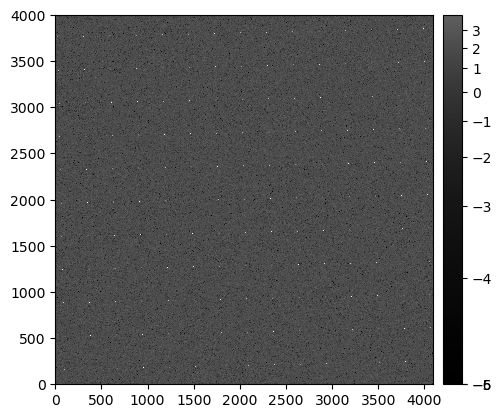

In [9]:
# create a matplotlib.pyplot figure
fig = plt.figure()
#Display the image with lsst.afw.display

#The next task is to let AFWDisplay know that we want it to use matplotlib as our default display backend.
#To do this, we use the setDefaultBackend() function. Remember that we made an alias to lsst.afw.display called afwDisplay in the import
afwDisplay.setDefaultBackend('matplotlib')
# get an alias to the lsst.afw.display.Display() method
display = afwDisplay.Display(frame=fig)
# set the image stretch algorithm and range
display.scale('asinh', 'zscale')
# load the image into the display
display.mtv(calexp.image)
# show the corresponding pyplot figure
plt.show()
# clean up memory
remove_figure(fig)

#Esiste un tutorial per l'utilizzo di  afw_display che il numero 3 del tutorial, da studiare perche' questo e' lo standard, 
#in particolare fornisce funzioi su come fare i cut, le composizioni di immagini  etc...)
#https://github.com/rubin-dp0/tutorial-notebooks/blob/main/03a_Image_Display_and_Manipulation.ipynb

#invece il noteook dopo va su strumenti un po' piu' potenti di data display come firefly che ti apre figure iterattive che credo sia il caso di imparare

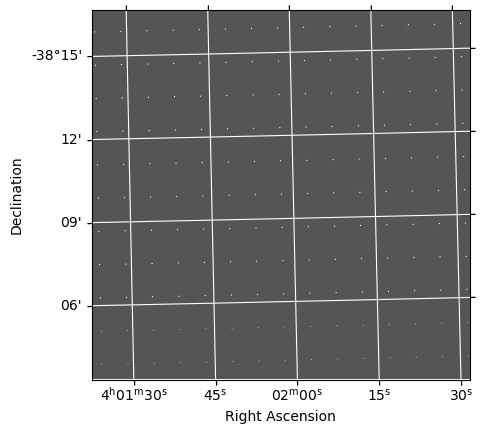

In [10]:
fig = plt.figure()
plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))
calexp_extent = (calexp.getBBox().beginX, calexp.getBBox().endX,
                 calexp.getBBox().beginY, calexp.getBBox().endY)
im = plt.imshow(calexp.image.array, cmap='gray', vmin=-200.0, vmax=400,
                extent=calexp_extent, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()
remove_figure(fig)

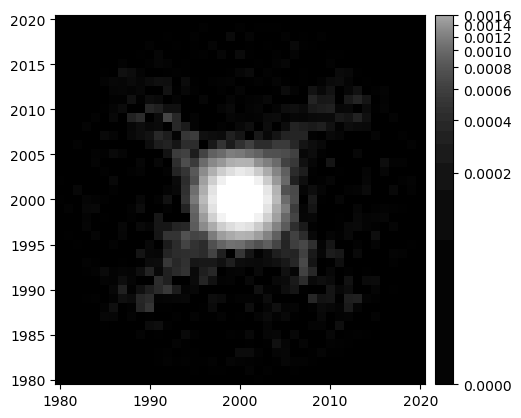

In [11]:
#EXPLORE PSF
psf = calexp.getPsf()
#The PSF object can be used to get a realization of a PSF at a specific point
from lsst.geom import PointD
psfimage = psf.computeImage(PointD(2000.,2000.))
display = afwDisplay.Display()
display.scale('asinh', min=0.0, max=2.e-4, unit='absolute')
display.mtv(psfimage)

In [12]:
#retrive background from calexp 
bkgd = butler.get('calexpBackground', **dataId)

Text(0.5, 1.0, 'Local Polynomial Background')

<Figure size 640x480 with 0 Axes>

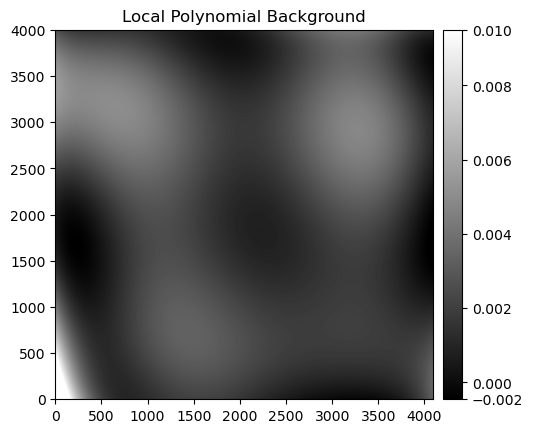

In [13]:
#Visualize
afwDisplay.setDefaultBackend('matplotlib')

plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(bkgd.getImage())
plt.title("Local Polynomial Background")

In [15]:
# Define the pixel coordinates of a point of interest
# (in this case, basically the central  point within the image)
x_target, y_target = 2000, 2000
#width, height = 4000, 4000
#xmin, ymin = x_target-width//2, y_target-height//2
point = geom.Point2D(x_target, y_target)

# Get the PSF at our point of interest()
psf = calexp.getPsf()

In [77]:
#calcoliamo il Determinant radius

sigma = psf.computeShape(point).getDeterminantRadius()
print('psf determinant radius={:.2f} pixel'.format(sigma))

pixelScale = calexp.getWcs().getPixelScale().asArcseconds()
print(pixelScale)

# The factor of 2.355 converts from std to fwhm
print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))

psf determinant radius=1.55 pixel
0.1999999999716517
psf fwhm = 0.73 arcsec


In [78]:
#calcoliamo il TraceRadius
TraceRadius=psf.computeShape(point).getTraceRadius()
print('psf trace radius={:.2f} pixel'.format(TraceRadius))

pixelScale = calexp.getWcs().getPixelScale().asArcseconds()

# The factor of 2.355 converts from std to fwhm
print('psf fwhm = {:.2f} arcsec'.format(TraceRadius*pixelScale*2.355))

psf trace radius=1.55 pixel
psf fwhm = 0.73 arcsec


In [79]:
#Se invece vogliamo determinare la shape a partire dai momenti adattivi.

Ixx=psf.computeShape(point).getIxx()
Iyy=psf.computeShape(point).getIyy()
Ixy=psf.computeShape(point).getIxy()

In [80]:
#Questo ci serve per capire come e' stato calcolato il trace radius e il determminant radius
assert np.isclose(TraceRadius, np.sqrt((Ixx + Iyy) / 2.))
assert np.isclose(sigma, (Ixx * Iyy - Ixy**2)**(1. / 4.))

In [81]:
# Ellipticity
from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius

q = Quadrupole(Ixx, Iyy, Ixy)
s = SeparableDistortionTraceRadius(q)
theta = np.arctan2(2. * Ixy, Ixx - Iyy) / 2.
e1 = (Ixx - Iyy) / (Ixx + Iyy)
e2 = (2. * Ixy) / (Ixx + Iyy)
e = np.sqrt(e1**2 + e2**2)
ex = e * np.cos(theta)
ey = e * np.sin(theta)
theta_alternate = np.arctan2(e2, e1) / 2.
assert np.allclose(theta, theta_alternate)
e = np.sqrt(e1**2 + e2**2)
ex = e * np.cos(theta)
ey = e * np.sin(theta)

In [82]:
# Ellipticity
from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius

q = Quadrupole(Ixx, Iyy, Ixy)
s = SeparableDistortionTraceRadius(q)
assert np.isclose(s.getE1(), (Ixx - Iyy) / (Ixx + Iyy)) # e1
print('e1 =', s.getE1())
assert np.isclose(s.getE2(), (2. * Ixy) / (Ixx + Iyy)) # e2
print('e2 =', s.getE2())
assert np.isclose(s.getEllipticity().getTheta(), np.arctan2(2. * Ixy, Ixx - Iyy) / 2.) # theta
print('theta =', s.getEllipticity().getTheta())

e1 = 0.025489117478294982
e2 = 0.0030979532371336444
theta = 0.06047350759555679


In [83]:
regular_grid_or_star_positions = 0

if regular_grid_or_star_positions == 0:
    # Per la visualizzazione della PSF su griglia regolare
    n_grid = 200
    x_array = np.arange(0, calexp.getDimensions()[0], n_grid)
    y_array = np.arange(0, calexp.getDimensions()[1], n_grid)    
    xx, yy = np.meshgrid(x_array, y_array)
    xx_for_zip = xx.flatten()
    yy_for_zip = yy.flatten()
    xxshape = xx.shape

elif regular_grid_or_star_positions == 1:
    # Per la visualizzazione della PSF sulle coordinate delle stelle
    xx = [l.getCentroid()[0] for l in sources]
    yy = [l.getCentroid()[1] for l in sources]
    xx_for_zip = xx
    yy_for_zip = yy
    xxshape = len(xx)

In [84]:
#For visualization purposes, let's evaluate the PSF model at grid of points across the image
from lsst.geom import Point2D

size = []
i_xx = []
i_yy = []
i_xy = []

for x, y in zip(xx_for_zip, yy_for_zip):
    point = Point2D(x, y)
    shape = psf.computeShape(point)
    size.append(shape.getTraceRadius())
    i_xx.append(shape.getIxx())
    i_yy.append(shape.getIyy())
    i_xy.append(shape.getIxy())
size = np.reshape(size, xxshape)
i_xx = np.reshape(i_xx, xxshape)
i_yy = np.reshape(i_yy, xxshape)
i_xy = np.reshape(i_xy, xxshape)

theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
e1 = (i_xx - i_yy) / (i_xx + i_yy)
e2 = (2. * i_xy) / (i_xx + i_yy)
theta_alternate = np.arctan2(e2, e1) / 2.
assert np.allclose(theta, theta_alternate)
e = np.sqrt(e1**2 + e2**2)
ex = e * np.cos(theta)
ey = e * np.sin(theta)

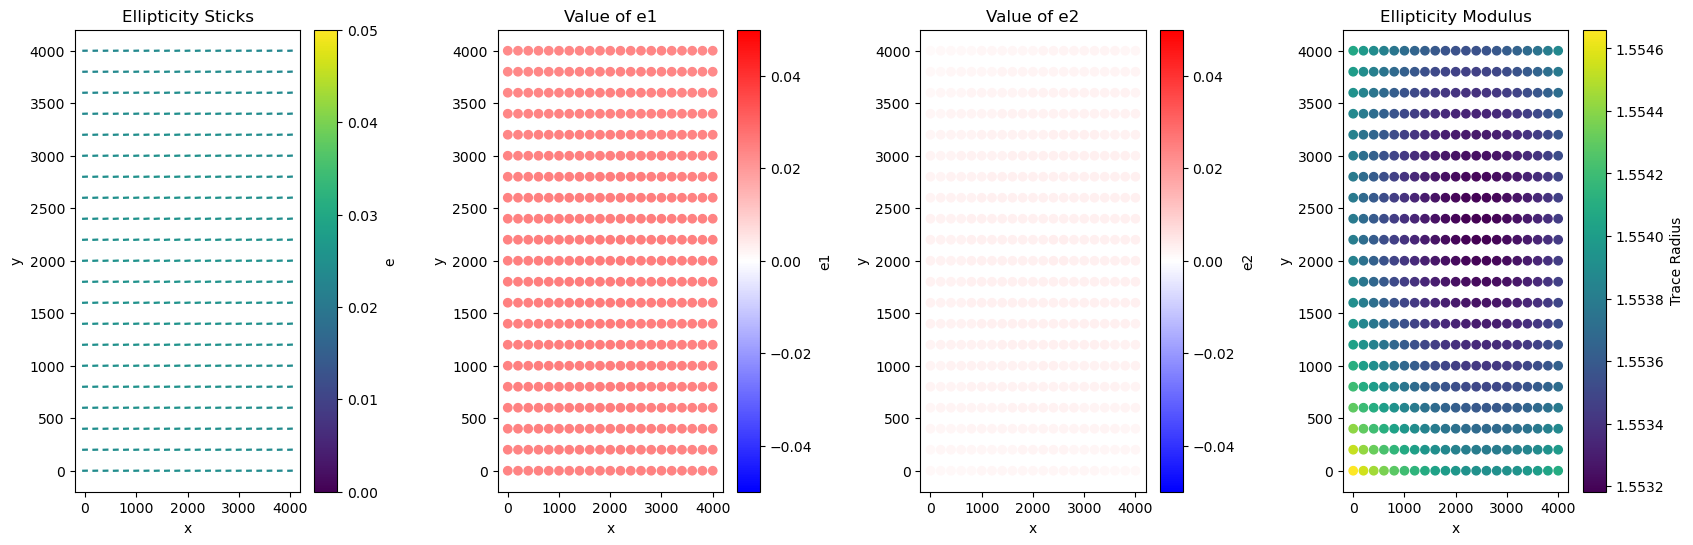

In [85]:
fig = plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 4, 1)
plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.01)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(0., 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Sticks')

plt.subplot(1, 4, 2)
plt.scatter(xx, yy, c=e1, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e1')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Value of e1')

plt.subplot(1, 4, 3)
plt.scatter(xx, yy, c=e2, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e2')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Value of e2')

plt.subplot(1, 4, 4)
plt.scatter(xx, yy, c=size)
colorbar = plt.colorbar(label='Trace Radius')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Modulus');

fig.savefig('ellipticity_map.pdf')

Text(0.5, 1.0, 'Ellipticity Sticks')

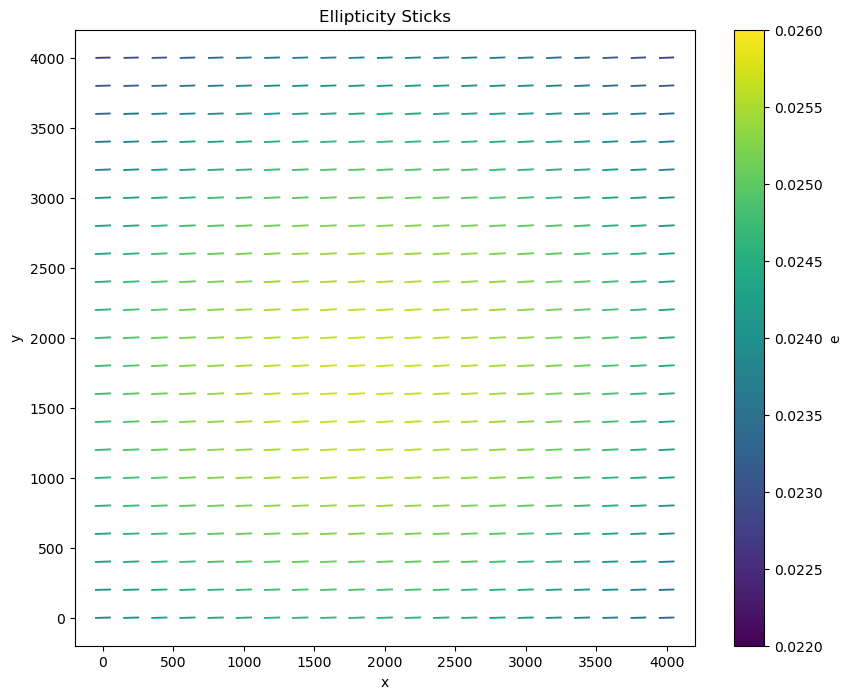

In [89]:
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.003)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
# plt.clim(0., 0.05)
plt.clim(0.022, 0.026)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Sticks')